<a href="https://colab.research.google.com/github/PranjalChamaria/2201CS55-apr/blob/main/apr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (48842, 15)
Missing values per column:
 age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
Train shape: (39073, 14) Test shape: (9769, 14)
Best Logistic Regression parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best Logistic Regression CV accuracy: 0.8526860052850658
Best SVM parameters: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
Best SVM CV accuracy: 0.8488734950891829

=== Logistic Regression (Full Data) ===
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      7431
           1       0.74      0.60      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.

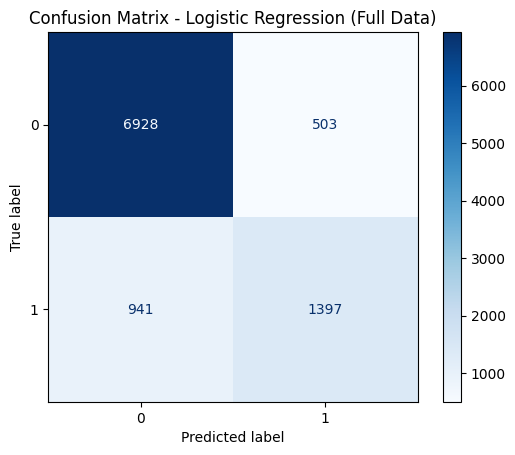

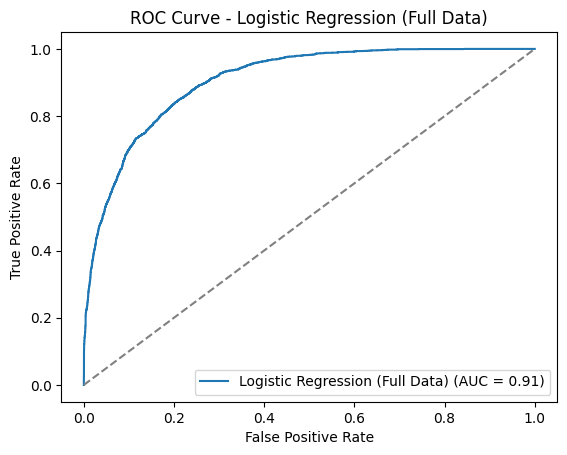


=== SVM (Subset 10k) ===
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1518
           1       0.75      0.56      0.65       482

    accuracy                           0.85      2000
   macro avg       0.81      0.75      0.78      2000
weighted avg       0.84      0.85      0.84      2000



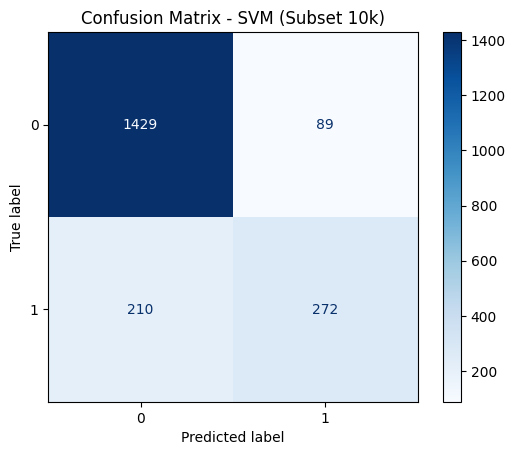

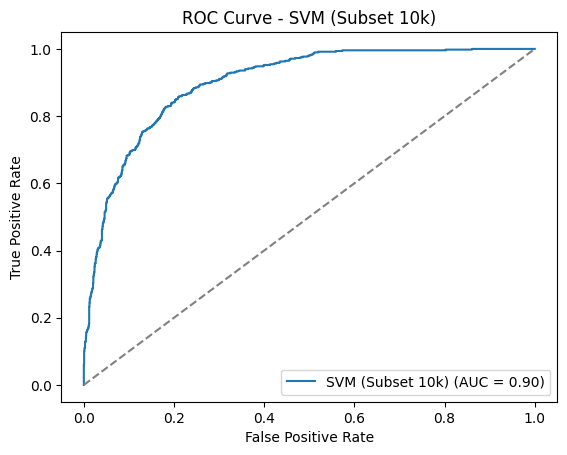

Logistic Regression CV scores: [0.85034292 0.85198076 0.85687961 0.85217035 0.85104423] Mean: 0.8524835724062871
SVM CV scores (subset 10k): [0.84163167 0.85478548 0.849985  ] Mean: 0.8488007169043238


In [3]:
# Adult Income Classification with Logistic Regression & SVM

# ============================
# 1. Setup
# ============================
!pip install seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# ============================
# 2. Load Dataset
# ============================
url_train = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

col_names = ["age","workclass","fnlwgt","education","education-num","marital-status",
             "occupation","relationship","race","sex","capital-gain","capital-loss",
             "hours-per-week","native-country","income"]

train_data = pd.read_csv(url_train, header=None, names=col_names, na_values=" ?", skipinitialspace=True)
test_data = pd.read_csv(url_test, header=0, names=col_names, na_values=" ?", skipinitialspace=True)

data = pd.concat([train_data, test_data], axis=0)
print("Dataset shape:", data.shape)

data.head()

# ============================
# 3. Preprocessing
# ============================
print("Missing values per column:\n", data.isnull().sum())
data = data.dropna()

data["income"] = data["income"].apply(lambda x: 1 if ">50K" in str(x) else 0)

X = data.drop("income", axis=1)
y = data["income"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])

# ============================
# 4. Train-Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ============================
# 5. Logistic Regression Model (Full dataset)
# ============================
log_reg = Pipeline(steps=[("preprocessor", preprocessor),
                         ("classifier", LogisticRegression(max_iter=1000))])

param_grid_lr = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression parameters:", grid_lr.best_params_)
print("Best Logistic Regression CV accuracy:", grid_lr.best_score_)

# ============================
# 6. SVM Model (Subset of 10k rows, Linear Kernel only)
# ============================
sample = data.sample(n=10000, random_state=42)
X_svm = sample.drop("income", axis=1)
y_svm = sample["income"]

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, stratify=y_svm, random_state=42)

svm_clf = Pipeline(steps=[("preprocessor", preprocessor),
                          ("classifier", SVC(probability=True))])

param_grid_svm = {
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear"]
}

grid_svm = GridSearchCV(svm_clf, param_grid_svm, cv=3, scoring="accuracy", n_jobs=-1)
grid_svm.fit(X_train_svm, y_train_svm)

print("Best SVM parameters:", grid_svm.best_params_)
print("Best SVM CV accuracy:", grid_svm.best_score_)

# ============================
# 7. Evaluation (Logistic Regression vs SVM)
# ============================
models = {
    "Logistic Regression (Full Data)": (grid_lr, X_test, y_test),
    "SVM (Subset 10k)": (grid_svm, X_test_svm, y_test_svm)
}

for name, (model, X_eval, y_eval) in models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_eval)
    print(classification_report(y_eval, y_pred))

    cm = confusion_matrix(y_eval, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    y_prob = model.predict_proba(X_eval)[:,1]
    auc = roc_auc_score(y_eval, y_prob)
    fpr, tpr, _ = roc_curve(y_eval, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

# ============================
# 8. Cross-validation results
# ============================
cv_lr = cross_val_score(grid_lr.best_estimator_, X, y, cv=5, scoring="accuracy")
cv_svm = cross_val_score(grid_svm.best_estimator_, X_svm, y_svm, cv=3, scoring="accuracy")

print("Logistic Regression CV scores:", cv_lr, "Mean:", cv_lr.mean())
print("SVM CV scores (subset 10k):", cv_svm, "Mean:", cv_svm.mean())
